In [1]:
import numpy as np
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import umap

from sklearn.datasets import (
    make_blobs, load_iris, load_wine, load_digits, 
    fetch_openml, load_breast_cancer
)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from lib.dice_mod import Gainer, random_opt, gradient_ascent, plot_heatmap, adam_opt

%load_ext autoreload
%autoreload 2

2025-05-24 17:18:58.971758: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


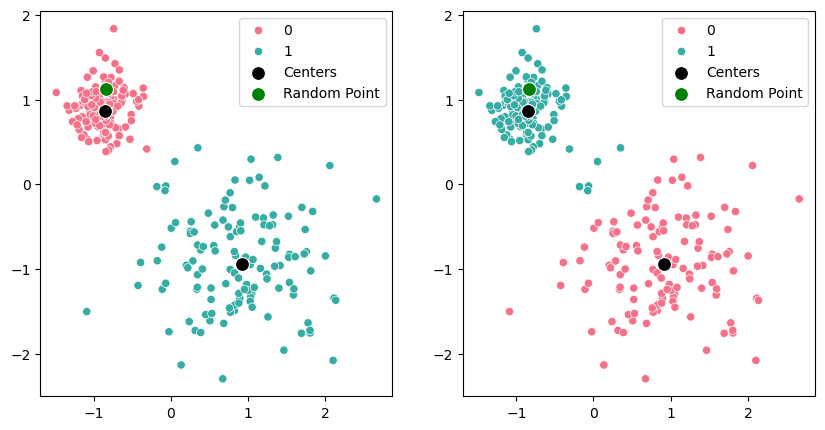

In [17]:
k = 2

X, y = make_blobs(centers=k, cluster_std=[1.0, 2.5], n_features=2, n_samples=250, random_state=42)
# X, y = make_blobs(centers=k, cluster_std=1.6, n_features=2, n_samples=250, random_state=1234)
# X, y = load_breast_cancer(return_X_y=True)
# X, y = load_iris(return_X_y=True)
X = StandardScaler().fit_transform(X)

km = KMeans(n_clusters=k)
yy = km.fit_predict(X)
C = km.cluster_centers_

# random point from X:
# np.random.seed(123)
np.random.seed(None)
random_point = X[[np.random.randint(0, X.shape[0])]]
instance_cluster = km.predict(random_point)[0]


def plot(X, y, C, x, pca=False, use_umap=False):
    assert not (pca and use_umap)
    if use_umap or pca:
        reducer = umap.UMAP() if use_umap else PCA(n_components=2)
        X = reducer.fit_transform(X)
        C = reducer.transform(C)
        x = reducer.transform(x)

    unique_labels = np.unique(y)
    palette = sns.color_palette("husl", len(unique_labels))

    _fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for ax, h in zip(axs, [y, yy]):
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=h, palette=palette, legend="full", ax=ax)
        sns.scatterplot(x=C[:, 0], y=C[:, 1], color='black', s=100, marker='o', label='Centers', ax=ax)
        sns.scatterplot(x=x[:, 0], y=x[:, 1], color='green', s=100, marker='o', label='Random Point', ax=ax)
    plt.show()

plot(X, y, C, random_point, pca=False, use_umap=False)

# Example usage

iter: 262, score: 0.8217423406556
target: 0, prediction: 0


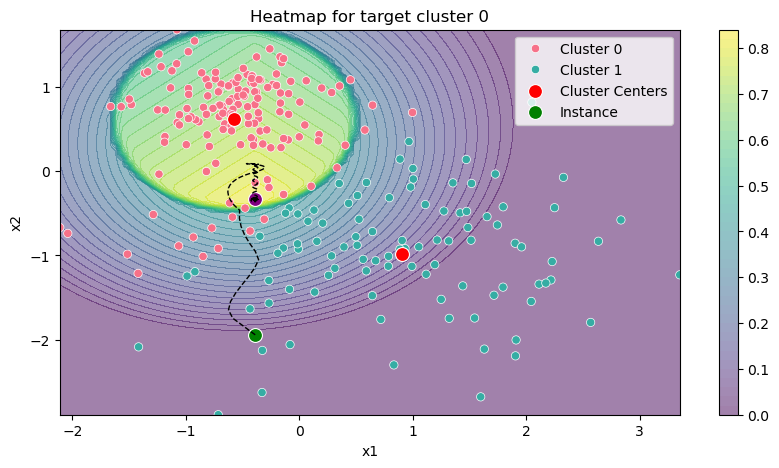

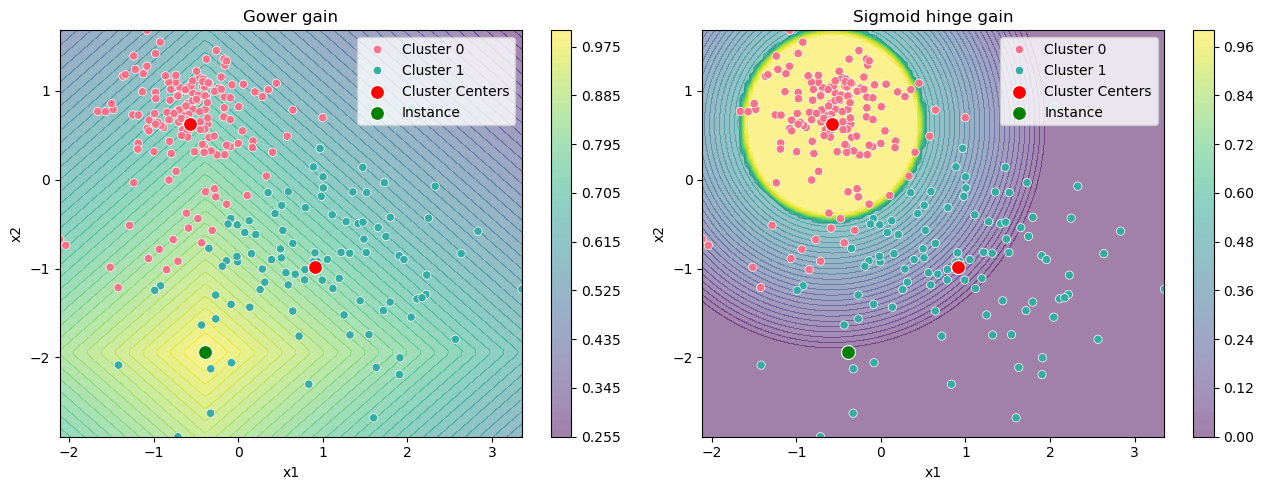

In [15]:

targets = set(range(k))
targets.remove(instance_cluster)
fig, axs = plt.subplots(1, len(targets), figsize=(10, 5))

axs = [axs]

for i, target in enumerate(targets):
    if target == instance_cluster: continue
    l = Gainer(C, X, target, random_point, eps=0.0)
    # sol, hist = gradient_ascent(random_point, l.gain, dbg=False, lr=0.1, max_iter=1000)
    sol, hist = adam_opt(random_point, l.gain)
    # sol, hist = random_opt(random_point, l.gain)
    print(f"target: {target}, prediction: {int(km.predict(sol.reshape(1, -1))[0])}")
    plot_heatmap(
        X, yy, C, random_point, l.gain, target_cluster=target, 
        use_pca=False, 
        solutions=[sol], 
        histories=[hist],
        ax=axs[i],
    )
    axs[i].set_title(f'Heatmap for target cluster {target}')
    fig.colorbar(axs[i].collections[0], ax=axs[i])


fig, axes = plt.subplots(1, len(l.gain_weights.keys()), figsize=(13, 5))
for i, gain_fn in enumerate(l.gain_weights.keys()):
    plot_heatmap(X, yy, C, random_point, gain_fn, target_cluster=0, use_pca=False, ax=axes[i])
    axes[i].set_title(gain_fn.__name__.replace('_', ' ').capitalize())
    fig.colorbar(axes[i].collections[0], ax=axes[i])
fig.tight_layout()
plt.show()

<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_57187/1602981689.py:30: SyntaxWarning: invalid escape sequence '\e'
  marker=markers[i], label=f"CF ($\epsilon={epses[i]}$)",


iter: 465, score: 0.7331054670078956
iter: 542, score: 0.7116256808259686
iter: 511, score: 0.6794118721569445
iter: 461, score: 0.6257395674407452
iter: 552, score: 0.5720923431319652
iter: 273, score: 0.26949164462706365


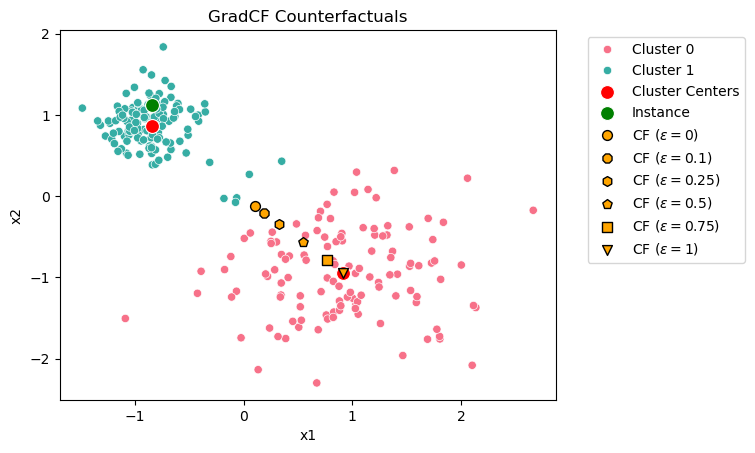

In [19]:
import pandas as pd
from lib.util import sparsity_fix

target = 0
epses = [0, 0.1, 0.25, 0.5, 0.75, 1]

cfs = []
for i, eps in enumerate(epses):
    l = Gainer(C, X, target, random_point, eps=eps)
    sol, hist = adam_opt(random_point, l.gain)
    cfs.append(sol)



# Plot data points, cluster centers, and random point
unique_labels = np.unique(y)
palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['label'] = [f'Cluster {i}' for i in yy]
df = df.sort_values(by='label')

sns.scatterplot(df, x='x1', y='x2', hue='label', palette=palette)
sns.scatterplot(x=C[:, 0], y=C[:, 1], color='red', s=100, marker='o', label='Cluster Centers')
sns.scatterplot(x=random_point[:, 0], y=random_point[:, 1], color='green', s=100, marker='o', label='Instance')

for i, s in enumerate(cfs):
    markers = ['o', '8', 'h', 'p', 's', 'v']  # Different marker shapes
    sns.scatterplot(x=s[:, 0], y=s[:, 1], color='orange', s=50, 
                    marker=markers[i], label=f"CF ($\epsilon={epses[i]}$)",
                    edgecolor='black', linewidth=1)

# for i, s in enumerate(cfs):
#     s = sparsity_fix(s, random_point, X, km)
#     markers = ['o', '8', 'h', 'p', 's', 'v']  # Different marker shapes
#     sns.scatterplot(x=s[:, 0], y=s[:, 1], color='yellow', s=50, 
#                     marker=markers[i], label=f"CF ($\epsilon={epses[i]}$)",
#                     edgecolor='black', linewidth=1)

plt.title(f'GradCF Counterfactuals')
#place legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 513, score: 0.8949799680036886
Original counterfactual: [[-0.76399036 -0.60363081]]
instance: [[-0.34276112 -0.30785138]]
Original cluster: [2]
costs: [0. 0.]
Fixed: [[-0.34276112 -0.60363081]]
break with [[-0.76399036 -0.60363081]]


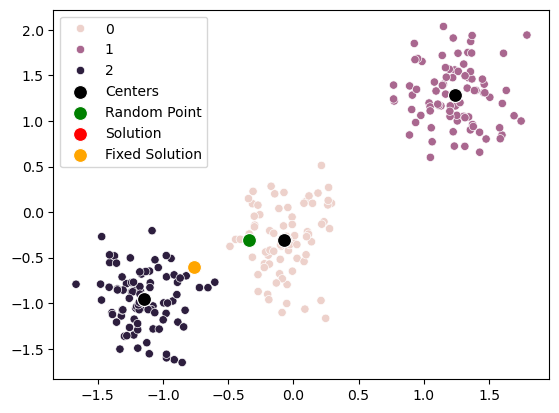

In [4]:
from lib.util import sparsity_fix

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=yy, legend="full")
sns.scatterplot(x=C[:, 0], y=C[:, 1], color='black', s=100, marker='o', label='Centers')
sns.scatterplot(x=random_point[:, 0], y=random_point[:, 1], color='green', s=100, marker='o', label='Random Point')

l = Gainer(C, X, 2, random_point, eps=0.0)
sol, hist = adam_opt(random_point, l.gain)
sns.scatterplot(x=sol[:, 0], y=sol[:, 1], color='red', s=100, marker='o', label='Solution')

fixed = sparsity_fix(sol, random_point, km)
sns.scatterplot(x=fixed[:, 0], y=fixed[:, 1], color='orange', s=100, marker='o', label='Fixed Solution')

plt.show()

# MNIST 784 Example

In [5]:
def load_mnist_clustering():
    X, target = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = X.astype(np.float64)
    target = target.astype(int)
    print(f"X shape: {X.shape}")

    # mdist = np.max(pdist(X)) <----- Extremely slow! value is hardcoded below
    # mdist = 4303.319300261137
    # X = X / mdist
    # X = StandardScaler().fit_transform(X)

    km = KMeans(n_clusters=10, random_state=42)
    y = km.fit_predict(X)
    C = km.cluster_centers_
    return X, y, C, target, km

X, y, C, target, km = load_mnist_clustering()

X shape: (70000, 784)


real label: 3
cluster label: 3


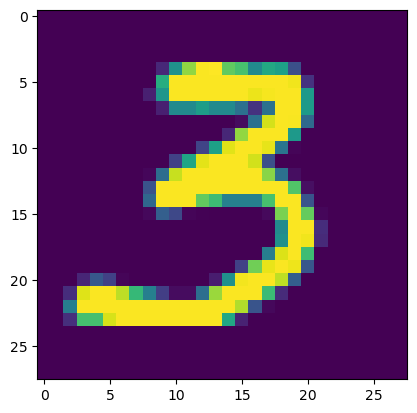

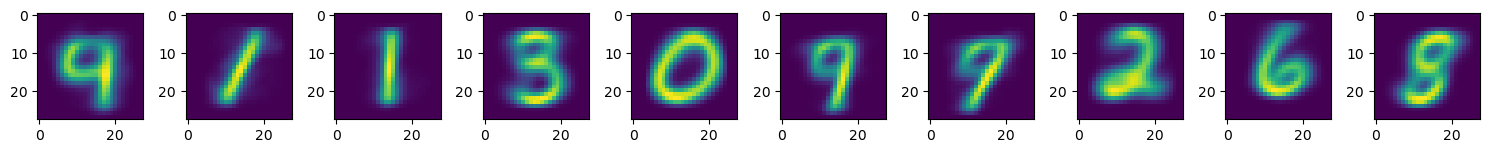

In [6]:
idx = 975
random_point = X[idx].reshape(1, -1)

def showim(x, ax = None):
    p = plt if ax is None else ax
    p.imshow(x[0].reshape(28, 28))
    if ax is None:
        plt.show()

print(f"real label: {target[idx]}")
print(f"cluster label: {y[idx]}")
showim(random_point)

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, c in enumerate(C):
    showim(c.reshape(1, -1), ax=axes[i])
plt.tight_layout()
plt.show()


X: (70000, 784)
C: (10, 784)
x: (1, 784)
iter: 1000, score: 0.3565165835283733
iter: 1000, score: 0.34103763725331093
iter: 1000, score: 0.32684472217656607
iter: 1000, score: 0.31378712230337247
iter: 1000, score: 0.30173217763122084
iter: 1000, score: 0.2905694339423529
iter: 1000, score: 0.28020274723076516
iter: 1000, score: 0.2705501479007466
iter: 1000, score: 0.26153846206710973
iter: 1000, score: 0.25310890263131974
iter: 1000, score: 0.24520669120163585


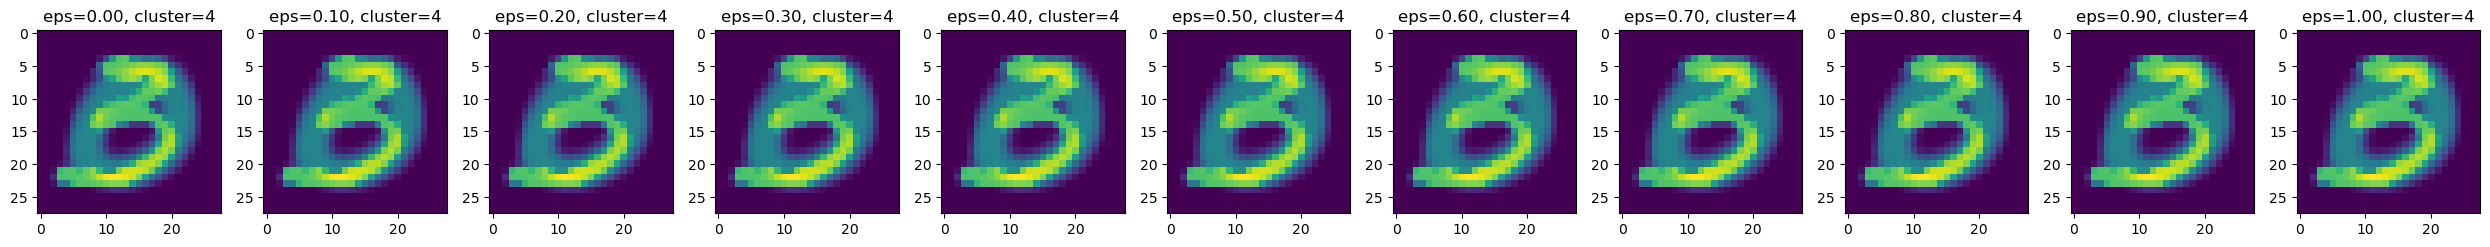

In [7]:
fig, axes = plt.subplots(1, 11, figsize=(25, 5))
l = Gainer(C, X, 4, random_point)
for i,e in enumerate(np.linspace(0,1,11)):
    l.eps = e
    # sol, _hist = gradient_ascent(random_point, l.gain, dbg=False, lr=0.1)
    sol, _hist = adam_opt(random_point, l.gain)
    showim(sol, ax=axes[i])
    axes[i].set_title(f"eps={e:.2f}, cluster={km.predict(sol)[0]}")
plt.tight_layout()
plt.show()